# Binary Classification - N01
Let's repeat the toy classification problem with moon dataset.
We will build a multi-input single-output neural network model with 1 hidden layer.

1. Training
    1. Prepare datasets: training and validation
        1. Load raw data.
        2. Rescale and reshape.
    2. Initialize model (with random parameters: w, b).
    3. Evaluate the model with metrics (e.g. BCE).
    4. Calculate gradients of loss.
    5. Update parameters a small step on the directions descending the gradient of loss.
    6. Repeat 3 to 5 until converge.



## 1. Prepare Datasets


In [28]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

### 1.1. Load raw training data

In [29]:
train_features_raw, train_labels_raw = make_moons(n_samples=1024, noise=0.2, random_state=3321)

# First impression on training set
print(f"Shape of training features: {train_features_raw.shape}, Shape of training labels: {train_labels_raw.shape}")
print(f"First 10 training features:\n{train_features_raw[:10]}")
print(f"First 10 training labels: \n{train_labels_raw[:10]}")

Shape of training features: (1024, 2), Shape of training labels: (1024,)
First 10 training features:
[[-0.86691851 -0.32027284]
 [ 1.70922817 -0.66094909]
 [ 0.95477398  0.28453102]
 [ 0.14465106  0.33336045]
 [ 0.58070122  0.65058253]
 [ 1.33531488 -0.2647643 ]
 [ 1.46344736 -0.55310411]
 [-1.20787839  0.52778545]
 [ 0.47737585 -0.2020379 ]
 [ 1.45674566 -0.27188258]]
First 10 training labels: 
[0 1 0 1 0 1 1 0 1 1]


### 1.2. Load raw validation dataset

In [30]:
val_features_raw, val_labels_raw = make_moons(n_samples=200, noise=0.2, random_state=1233)

# First impression on validation set
print(f"Shape of validation features: {val_features_raw.shape}, Shape of labels: {val_labels_raw.shape}")
print(f"First 10 validation features:\n{val_features_raw[:10]}")
print(f"First 10 validation labels: \n{val_labels_raw[:10]}")

Shape of validation features: (200, 2), Shape of labels: (200,)
First 10 validation features:
[[ 1.81920012 -0.07001386]
 [ 1.29383483 -0.08303255]
 [-0.04563293  1.25025751]
 [-0.47393598  0.45549844]
 [ 0.59672836 -0.31026414]
 [ 0.45336053 -0.76049598]
 [-0.75966698  1.02141679]
 [ 0.08028369 -0.40812272]
 [ 1.01305328 -0.22327438]
 [ 0.35756441  0.83380544]]
First 10 validation labels: 
[1 1 0 0 1 1 0 1 1 0]


### 1.3. Pre-Process Raw Data
1. Standardize features matrix, $X$, using mean and standard deviation of training features (to prevent data leakage).
$$Z = \frac{X - \mu_{train}}{\sigma_{train}}$$
2. Reshape label vector.

Shape of reshaped training labels: (1024, 1)
Shape of reshaped validation labels: (200, 1)


Text(0.5, 1.0, 'Validation Set')

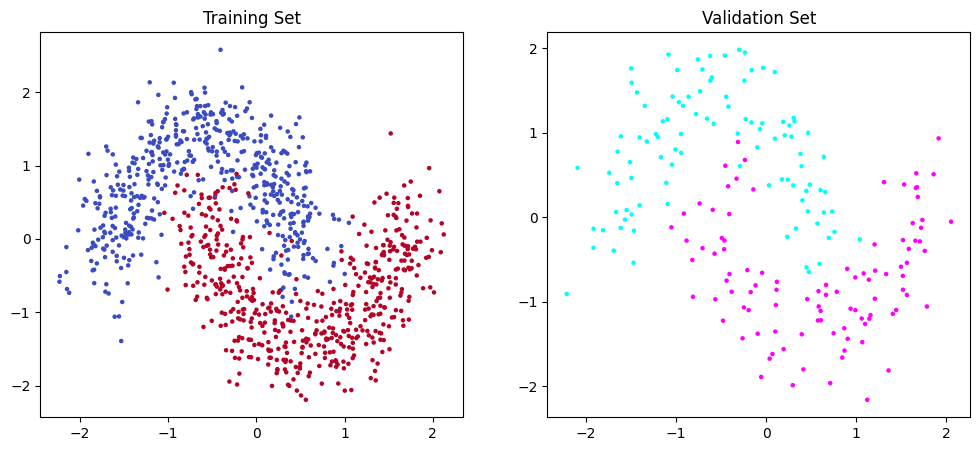

In [31]:
# Rescale by mean and standard deviation
features_train = (train_features_raw - train_features_raw.mean(axis=0)) / train_features_raw.std(axis=0)
features_val = (val_features_raw - train_features_raw.mean(axis=0)) / train_features_raw.std(axis=0)

# Reshape labels
labels_train = train_labels_raw.reshape(-1, 1)
print(f"Shape of reshaped training labels: {labels_train.shape}")
labels_val = val_labels_raw.reshape(-1, 1)
print(f"Shape of reshaped validation labels: {labels_val.shape}")

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    features_train[:, 0], 
    features_train[:, 1], 
    s=5*np.ones(labels_train.size), 
    c=labels_train, 
    cmap='coolwarm'
)
plt.title("Training Set")

plt.subplot(1, 2, 2)
plt.scatter(
    features_val[:, 0], 
    features_val[:, 1], 
    s=5*np.ones(labels_val.size), 
    c=labels_val, 
    cmap='cool'
)
plt.title("Validation Set")

## 2. N11 Model
 
$$
\begin{align*} 
    \hat{\mathbf{y}} &= \sigma(\mathbf{X}^{[1]} \cdot \mathbf{w}^{[2]T} + \mathbf{b}^{[2]}) \\
    &= \sigma(\sigma(\mathbf{X}^{[0]} \cdot \mathbf{W}^{[1]T} + \mathbf{b}^{[1]}) \cdot \mathbf{w}^{[2]T} + \mathbf{b}^{[2]})
\end{align*}
$$

In [32]:
def linear(in_features, weight, bias):
    out_features = in_features @ weight.T + bias
    return out_features

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward(in_features, params):
    features_1 = sigmoid(linear(in_features, params['W1'], params['b1']))
    predictions = sigmoid(linear(features_1, params['W2'], params['b2']))
    return predictions, features_1

# Sanity check
params_dummy = {
    'W1': np.random.normal(size=(4, features_train.shape[1])),  # (4, 2)
    'b1': np.random.normal(size=(1, 4)),
    'W2': np.random.normal(size=(1, 4)),
    'b2': np.random.normal()
}

preds_dummy, X1_dummy = forward(features_train[:3], params_dummy)
print(f"Hidden layer output (X1) shape: {X1_dummy.shape}")
print(f"Hidden layer output (X1):\n{X1_dummy}")
print(f"Shape of dummy predictions: {preds_dummy.shape}")
print(f"Dummy predictions:\n{preds_dummy}")
print(f"Dummy predicted class labels:\n{(preds_dummy >= 0.5).astype(int)}")

Hidden layer output (X1) shape: (3, 4)
Hidden layer output (X1):
[[0.80498809 0.16513505 0.91009205 0.19619226]
 [0.38175301 0.42672926 0.91545947 0.53238399]
 [0.49701821 0.86061755 0.87161081 0.46254085]]
Shape of dummy predictions: (3, 1)
Dummy predictions:
[[0.98401894]
 [0.97535809]
 [0.97514438]]
Dummy predicted class labels:
[[1]
 [1]
 [1]]


### 2.1. Visualize Descision Boundaries

Text(0.5, 1.0, 'Validation Set Decision Boundary (Dummy Params)')

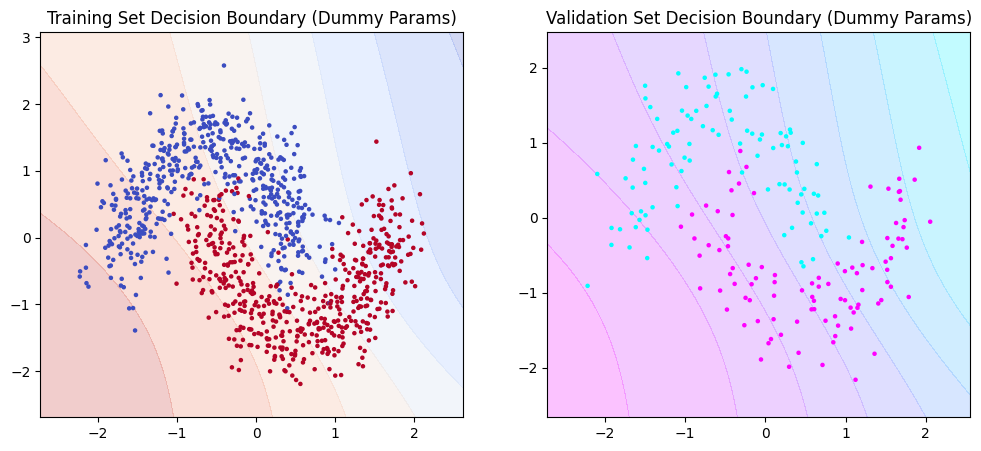

In [33]:
# Plot decision boundary
def plot_decision_boundary(pred_func, features, labels, color_map='coolwarm'):
    # Set min and max values and give it some padding
    x_min, x_max = features[:, 0].min() - 0.5, features[:, 0].max() + 0.5
    y_min, y_max = features[:, 1].min() - 0.5, features[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    zz = pred_func(np.c_[xx.ravel(), yy.ravel()])
    zz = zz.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, zz, cmap=color_map, alpha=0.25)
    plt.scatter(
        features[:, 0], 
        features[:, 1], 
        c=labels, 
        s=5*np.ones(labels.size), 
        cmap=color_map, 
    )

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(lambda x: forward(x, params_dummy)[0], features_train, labels_train)
plt.title("Training Set Decision Boundary (Dummy Params)")
plt.subplot(1, 2, 2)
plot_decision_boundary(lambda x: forward(x, params_dummy)[0], features_val, labels_val, 'cool')
plt.title("Validation Set Decision Boundary (Dummy Params)")

## 3. Model Performance Metrics
### 3.1. Binary Cross Entropy Loss
$\mathcal{L}(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{M} \sum_{i=1}^{M} -{}^{(i)}y \ln {}^{(i)}\hat{y} - (1 - {}^{(i)}y) \ln (1 - {}^{(i)}\hat{y}) = \overline{-\mathbf{y} \ln \hat{\mathbf{y}} - (1 - \mathbf{y}) \ln (1 - \hat{\mathbf{y}})}$



In [34]:
def bce_loss(preds, labels):
    error = -labels * np.log(preds) - (1 - labels) * np.log(1 - preds)
    return error.mean()

print(f"BCE Loss: {bce_loss(preds_dummy, labels_train[:3])}")


BCE Loss: 2.6186577503267308


### 3.2. Accuracy
$$Accuracy = \frac{TP + TN}{TP + FP + FN + TN}$$

> For classification problems, other metrics such as sensitivity and precision are also important.

In [35]:
def accuracy(preds, labels):
    preds_binary = (preds >= 0.5).astype(int)
    return (preds_binary == labels).mean()

print(f"Accuracy: {accuracy(preds_dummy, labels_train[:3])}")

Accuracy: 0.3333333333333333


## 4. Back-Propagate Gradients of Loss
$$\frac{\partial \mathcal{L}}{\partial \mathbf{w}^{[2]}} = \frac{1}{M} (\mathbf{\hat{y}} - \mathbf{y})^T \cdot \mathbf{X}^{[1]}$$

$$\frac{\partial \mathcal{L}}{\partial b^{[2]}} = \overline{(\mathbf{\hat{y}} - \mathbf{y})}$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} = (\mathbf{\hat{y}} - \mathbf{y})^T \cdot \mathbf{w}^{[2]}$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} = \frac{1}{M} [(\mathbf{\hat{y}} - \mathbf{y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]})]^T \cdot \mathbf{X}^{[0]}$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{[1]}} = \overline{
    (\mathbf{\hat{y}} - \mathbf{y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]})
} \text{, on 1st dimension}
$$


In [36]:
def backward(in_features, features_1, predictions, labels, params):
    M = labels.shape[0]
    dL_dW2 = (predictions - labels).T @ features_1 / M
    dL_b2 = (predictions - labels).mean()
    dL_dX1 = (predictions - labels) @ params['W2']
    dL_dW1 = (dL_dX1 * features_1 * (1 - features_1)).T @ in_features / M
    dL_db1 = (dL_dX1 * features_1 * (1 - features_1)).mean(axis=0)
    return {
        'dW2': dL_dW2,
        'db2': dL_b2,
        'dW1': dL_dW1,
        'db1': dL_db1
    }   

# Sanity check
grads_dummy = backward(features_train[:3], X1_dummy, preds_dummy, labels_train[:3], params_dummy)
for k, v in grads_dummy.items():
    print(f"{k}: {v}") 
    print(f"Shape of {k}: {v.shape}")   

dW2: [[0.42246031 0.33040232 0.57431184 0.21032735]]
Shape of dW2: (1, 4)
db2: 0.6448404712672834
Shape of db2: ()
dW1: [[-0.06898686 -0.07474696]
 [ 0.01326495  0.01028187]
 [-0.01376286 -0.01396402]
 [-0.04147552 -0.04423839]]
Shape of dW1: (4, 2)
db1: [ 0.22089963 -0.02057071  0.03608799  0.13010012]
Shape of db1: (4,)


## 5. Iterative Parameter Optimization

In [37]:
# Initialize parameters
params = {
    'W1': np.random.normal(0, 1e-4, (16, features_train.shape[1])),
    'b1': np.random.normal(0, 1e-4, (1, 16)),
    'W2': np.random.normal(0, 1e-4, (1, 16)),
    'b2': np.random.normal(0, 1e-4)
}

# Set hyperparameters
num_iters = 1000
learning_rate = 0.2

# Reserve metrics storage
losses_train, lossese_val = [], []
accuracies_train, accuracies_val = [], []

# Optimization iterations
for i in range(num_iters):
    # Forward pass
    preds_train, features_1_train = forward(features_train, params)
    preds_val, features_1_val = forward(features_val, params)
    # Compute loss and accuracy
    loss_train = bce_loss(preds_train, labels_train)
    loss_val = bce_loss(preds_val, labels_val)
    acc_train = accuracy(preds_train, labels_train)
    acc_val = accuracy(preds_val, labels_val)
    losses_train.append(loss_train)
    lossese_val.append(loss_val)
    accuracies_train.append(acc_train)
    accuracies_val.append(acc_val)
    # Log progress (every 50 iterations)   
    if i % 50 == 0 or i == num_iters - 1:
        print(f"Iter {i}: Train Loss {loss_train}, Train Acc {acc_train}")
        print(f"Iter {i}: Validation Loss {loss_val}, Validation Acc {acc_val}")
    # Back-propagation
    grads = backward(features_train, features_1_train, preds_train, labels_train, params)
    # Gradient descent parameter update
    params['W1'] -= learning_rate * grads['dW1']
    params['b1'] -= learning_rate * grads['db1']
    params['W2'] -= learning_rate * grads['dW2']
    params['b2'] -= learning_rate * grads['db2']


Iter 0: Train Loss 0.693147188016803, Train Acc 0.5
Iter 0: Validation Loss 0.6931471881030474, Validation Acc 0.5
Iter 50: Train Loss 0.6931470661454131, Train Acc 0.5
Iter 50: Validation Loss 0.6931470659518593, Validation Acc 0.5
Iter 100: Train Loss 0.6931460726457929, Train Acc 0.587890625
Iter 100: Validation Loss 0.6931460696559136, Validation Acc 0.61
Iter 150: Train Loss 0.6931365760761747, Train Acc 0.8427734375
Iter 150: Validation Loss 0.6931365442574149, Validation Acc 0.825
Iter 200: Train Loss 0.6930457174598326, Train Acc 0.845703125
Iter 200: Validation Loss 0.6930454033647274, Validation Acc 0.835
Iter 250: Train Loss 0.6921788881963794, Train Acc 0.8486328125
Iter 250: Validation Loss 0.6921758781807449, Validation Acc 0.83
Iter 300: Train Loss 0.6841277400009249, Train Acc 0.84765625
Iter 300: Validation Loss 0.6841011582489551, Validation Acc 0.83
Iter 350: Train Loss 0.6241837398727789, Train Acc 0.849609375
Iter 350: Validation Loss 0.6240693100072282, Validation

### 5.1. Plot Training Progress

(0.0, 1.0)

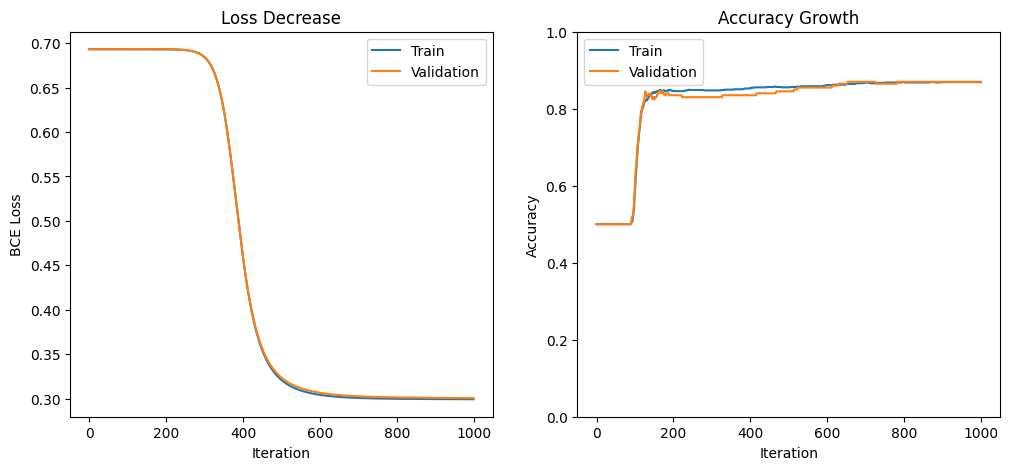

In [38]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_iters), losses_train, range(num_iters), lossese_val)
plt.legend(['Train', 'Validation'])
plt.title("Loss Decrease")
plt.xlabel("Iteration")
plt.ylabel("BCE Loss")
plt.subplot(1, 2, 2)
plt.plot(range(num_iters), accuracies_train, range(num_iters), accuracies_val)
plt.legend(['Train', 'Validation'])
plt.title("Accuracy Growth")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(0, 1)



### 5.2. Visualize Trained Descision Boundaries


Text(0.5, 1.0, 'Validation Set Decision Boundary')

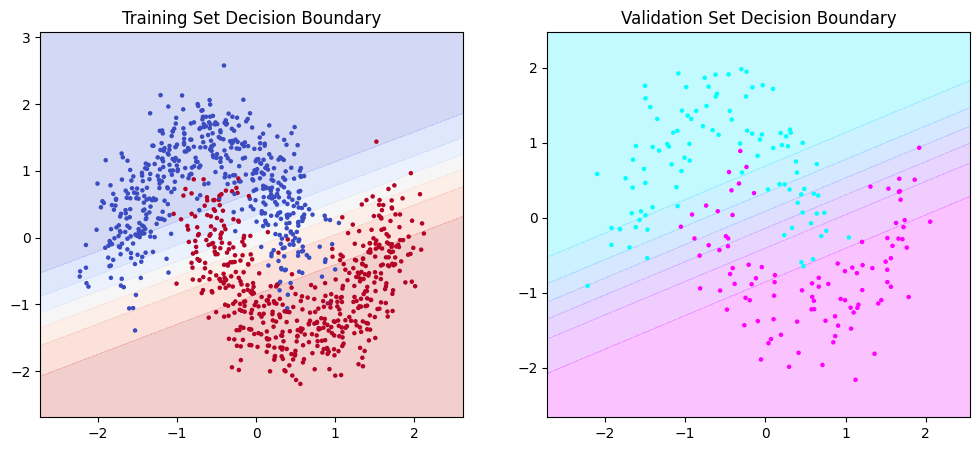

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(lambda x: forward(x, params)[0], features_train, labels_train)
plt.title("Training Set Decision Boundary")
plt.subplot(1, 2, 2)
plot_decision_boundary(lambda x: forward(x, params)[0], features_val, labels_val, 'cool')
plt.title("Validation Set Decision Boundary")